In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
from scipy import  stats
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor as GBR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from numpy.linalg import LinAlgError

D:\Software\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df_HS300 = pd.read_csv('df_000300.csv', header=0, index_col=0, encoding='utf-8')
df_ZZ500 = pd.read_csv('df_000905.csv', header=0, index_col=0, encoding='utf-8')

In [3]:
% matplotlib inline

In [4]:
def WT(index_list, wavefunc='db4', lv=4, m=1, n=4, plot=False):
    
    '''
    WT: Wavelet Transformation Function

    index_list: Input Sequence;
   
    lv: Decomposing Level；
 
    wavefunc: Function of Wavelet, 'db4' default；
    
    m, n: Level of Threshold Processing
   
    '''
   
    # Decomposing 
    coeff = pywt.wavedec(index_list,wavefunc,mode='sym',level=lv)   #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0 # sgn function 

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,n+1):   #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2*np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) -  Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0   # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])
    
    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)

        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]
        
        
    if plot:     
        denoised_index = np.sum(coeff, axis=0)   
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10,10),subplots=(2,1))
        data.plot(figsize=(10,5))
   
    return coeff

In [5]:
def AR_MA(coeff):
    
    '''
    AR_MA:  Autoregressive Moving Average Function
    
    coeff:  Input sequence disposed by WT (Wavelet Transformation Function)
    
    '''
    
    warnings.filterwarnings('ignore')
    order, model, results = [], [], []

    for i in range(1, len(coeff)):
        order.append(sm.tsa.arma_order_select_ic(coeff[i], ic='aic')['aic_min_order'])   # Select (p, q) by AIC criterion 
        model.append(ARMA(coeff[i], order=order[i-1]))
    
    for i in range(len(model)):
        new_order = list(order[i])
        while True:
            try:
                results.append(model[i].fit())
                
            except ValueError:                                              # Further determinte the appropriate (p, q) for the model
                new_order[1] = np.max((0, new_order[1]-1))
                model[i] = ARMA(coeff[i+1], order=new_order)         

            if len(results)>= i+1:
                break                
    
    return results

In [215]:
def NonlinReg(coeff, regressor='GBR', features=4, interval=0, length=1):
    
    '''
    NonlinReg: Non-linear Regression Model
    
    coeff: Input sequence disposed by WT (Wavelet Transformation Function)
    
    regressor: Non-linear regressor, 'GBR' default
    
    features: Days used to predict, 4 default
    
    interval: Prediction lagging, 0 default
    
    length: 1 default
    '''
    X, Y = [], []
    for i in range(len(coeff[0])):
        if i+features+interval < len(coeff[0]):
            X.append(coeff[0][i:i+features])
            Y.append(coeff[0][i+features+interval])
    X =  np.array(X)
    Y =  np.array(Y)

    if regressor == 'GBR':
        gbr = GBR(learning_rate=0.1, n_estimators=80, max_depth=2).fit(X, Y)
        
        X_ = copy.deepcopy(X)
        Y_ = copy.deepcopy(Y)
        for i in range(length):
            X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
            Y_ = np.concatenate((Y_, gbr.predict(X_[-1])))
    
    if regressor == 'SVR':
        svr = svm.SVR(kernel='rbf', C=100, gamma=1).fit(X, Y)

        X_ = copy.deepcopy(X)
        Y_ = copy.deepcopy(Y)
        for i in range(length):
            X_ = np.concatenate((X_, np.array([np.concatenate((X_[-1][-features+1:], Y_[[-interval-1]]))])))
            Y_ = np.concatenate((Y_, svr.predict(X_[-1])))
    
    return Y_[-1:]

In [209]:
def ModelEvaluation(index_predict, index_real): 
    '''
    ModelEvaluation: The function used to evaluate prediction model
    
    index_predict: The predict sequence
    
    index_real: The actual sequence 
    
    '''
    
    model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # The evaluation model list
    model_metrics_list = []  # The evaluation indicatiors list
    
    
    for m in model_metrics_name:  
        tmp_score = m(index_predict, index_real)  # compute each result
        model_metrics_list.append(tmp_score)
    df = pd.DataFrame(np.array([model_metrics_list]), index=['model'], columns=['ev', 'mae', 'mse', 'r2'])
    
    
    return df

In [120]:
start_day = '2010-01-04'
end_day = '2011-12-31'
test = df_HS300.loc[start_day:end_day,:]
test = test['CLOSE'] 
StockDate = df_HS300.loc['2012-01-01':'2012-01-20',:]
test_lag = StockDate['CLOSE']

In [125]:
window = 150
length = 1
index_predict, index_real = [], []
for i in range(30):
    test_window = test[i:i+window]
    coeff = WT(test_window, lv=4, n=4)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, length=length)
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window, window+length-1, dynamic=True))
    index_predict.append(Y_)
    index_real.append(test[i+window:i+window+length].values)

In [126]:
index_predict

[array([ 2841.76138757]),
 array([ 2890.61558684]),
 array([ 2916.49138175]),
 array([ 2920.0083976]),
 array([ 2932.56745125]),
 array([ 2891.33588578]),
 array([ 2887.34236701]),
 array([ 2904.39124593]),
 array([ 2853.37382961]),
 array([ 2843.79709213]),
 array([ 2843.53518853]),
 array([ 2893.34272647]),
 array([ 2902.00091461]),
 array([ 2885.8521642]),
 array([ 2911.1395584]),
 array([ 2917.1517374]),
 array([ 2946.42310304]),
 array([ 2970.7982863]),
 array([ 2974.88019253]),
 array([ 2936.67937801]),
 array([ 2932.21265397]),
 array([ 2956.64277704]),
 array([ 2961.3357587]),
 array([ 2929.16559461]),
 array([ 2876.48901836]),
 array([ 2862.57727508]),
 array([ 2844.88465224]),
 array([ 2851.21197113]),
 array([ 2896.13475493]),
 array([ 2886.52411235])]

In [127]:
index_real

[array([ 2922.083]),
 array([ 2942.291]),
 array([ 2937.362]),
 array([ 2955.395]),
 array([ 2898.333]),
 array([ 2896.192]),
 array([ 2911.827]),
 array([ 2843.023]),
 array([ 2850.093]),
 array([ 2858.566]),
 array([ 2915.01]),
 array([ 2903.188]),
 array([ 2884.042]),
 array([ 2921.393]),
 array([ 2920.205]),
 array([ 2975.09]),
 array([ 2983.108]),
 array([ 2980.967]),
 array([ 2926.46]),
 array([ 2932.554]),
 array([ 2962.319]),
 array([ 2965.009]),
 array([ 2913.194]),
 array([ 2857.789]),
 array([ 2861.369]),
 array([ 2849.828]),
 array([ 2857.476]),
 array([ 2905.029]),
 array([ 2880.907]),
 array([ 2874.812])]

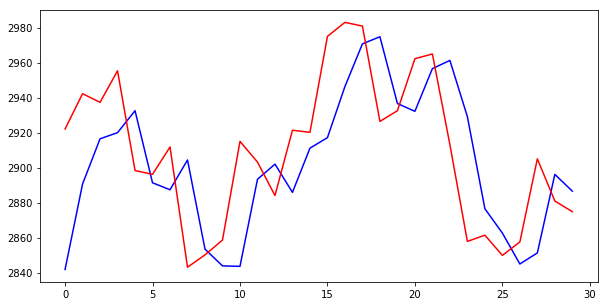

In [128]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict, 'blue')
plt.plot(index_real, 'red')

In [216]:
window = 150
length = 1
index_predict, index_real = [], []
for i in range(30):
    test_window = test[i:i+window]
    coeff = WT(test_window, lv=3, n=3)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, regressor='SVR', length=length)
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window-1, window+length-1, dynamic=True))
    index_predict.append(Y_+np.sum(np.array(D_series)[:,-1], axis = 0))
    index_real.append(test[i+window:i+window+length].values)

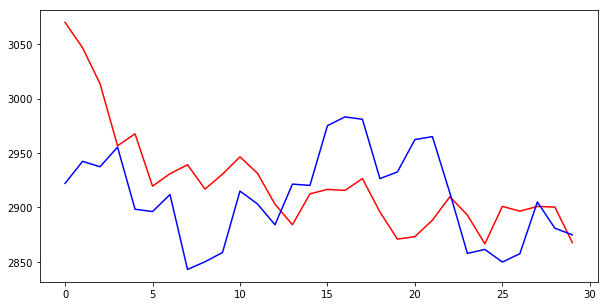

In [217]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict, 'red')
plt.plot(np.array(index_real)[:,0], 'blue') 

In [218]:
window = 150
length = 1
index_predict1, index_real1 = [], []
for i in range(30):
    test_window = test[i:i+window]
    coeff = WT(test_window, lv=3, n=3)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, regressor='GBR', length=length)
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window-1, window+length-1, dynamic=True))
    index_predict1.append(Y_+np.sum(np.array(D_series)[:,-1], axis = 0))
    index_real1.append(test[i+window:i+window+length].values)

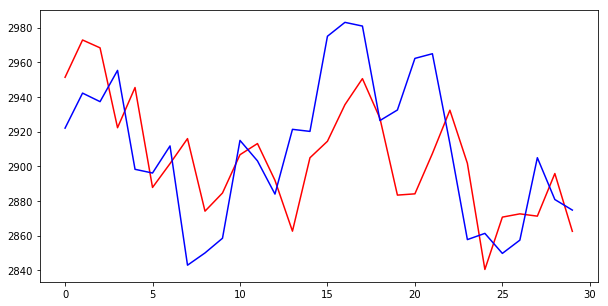

In [225]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot((np.array(index_predict)+np.array(index_predict1))/2, 'red')
plt.plot(np.array(index_real)[:,0], 'blue') 

In [226]:
ModelEvaluation((np.array(index_predict)+np.array(index_predict1))/2, index_real)

,ev,mae,mse,r2
model,-0.274181,30.626264,1345.288007,-0.291883


In [222]:
index_predict1

[array([ 2832.84922133]),
 array([ 2899.22095537]),
 array([ 2923.25079242]),
 array([ 2887.99380437]),
 array([ 2923.46543379]),
 array([ 2856.18687545]),
 array([ 2872.27560994]),
 array([ 2892.89304582]),
 array([ 2831.50591624]),
 array([ 2838.82973446]),
 array([ 2867.06814743]),
 array([ 2895.03452159]),
 array([ 2880.98702937]),
 array([ 2841.19420148]),
 array([ 2897.53063689]),
 array([ 2912.49487177]),
 array([ 2955.61095033]),
 array([ 2974.80958885]),
 array([ 2959.78214309]),
 array([ 2896.05152891]),
 array([ 2895.19378929]),
 array([ 2926.58852975]),
 array([ 2955.07056652]),
 array([ 2910.58957964]),
 array([ 2814.60055783]),
 array([ 2840.5428226]),
 array([ 2848.72390761]),
 array([ 2841.72373324]),
 array([ 2891.4914318]),
 array([ 2857.41956316])]

In [212]:
ModelEvaluation(index_predict[1:], index_real[:-1])

,ev,mae,mse,r2
model,0.892492,21.961744,638.082444,0.621368


In [213]:
ModelEvaluation(index_predict, index_real)

,ev,mae,mse,r2
model,0.215057,36.364726,1842.045746,-0.065741


In [185]:
D_series = []

In [182]:
np.array(D_series)[:,-1]

array([-10.96915602,  -2.018464  ,  -0.58835471,  -0.0225876 ])

In [183]:
np.sum(np.array(D_series)[:,-1], axis=0)

-13.598562333493401

In [184]:
index_predict.append(Y_+np.sum(np.array(D_series)[:,-1], axis = 0))
index_real.append(test[i+window:i+window+length].values)

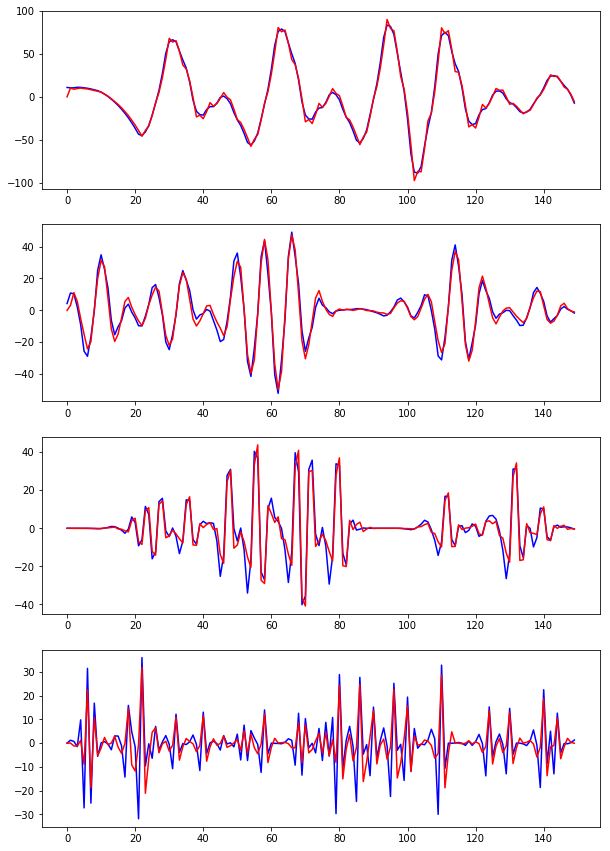

In [156]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coeff[i+1], 'blue')
    plt.plot(results[i].fittedvalues,'red')

In [158]:
results[0].fittedvalues[-1]

-5.5955097671163365

In [159]:
results[1].fittedvalues[-1]

-1.0782758566472581

In [160]:
results[2].fittedvalues[-1]

-0.34954142258453308

In [161]:
results[3].fittedvalues[-1]

-0.054625119695876467

In [164]:
results[0].predict(window-1, window+length-1, dynamic=True)

array([ -5.60261555, -10.96915602])

In [165]:
results[1].predict(window-1, window+length-1, dynamic=True)

array([-1.08314402, -2.018464  ])

In [167]:
results[2].predict(window-1, window+length-1, dynamic=True)

array([-0.34733799, -0.58835471])

In [168]:
results[3].predict(window-1, window+length-1, dynamic=True)

array([-0.05462512, -0.0225876 ])

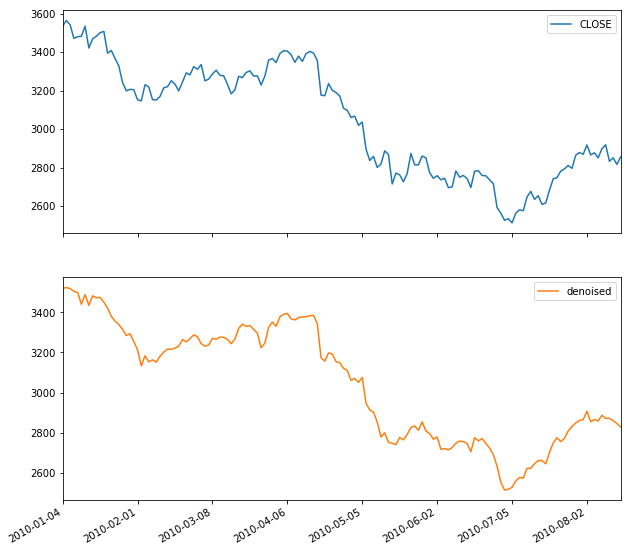

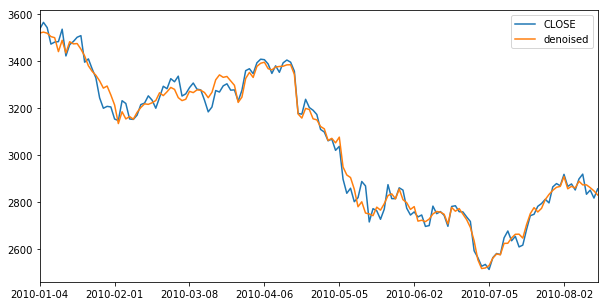

In [170]:
denoised_index = np.sum(coeff, axis=0)   

    # 在原dataframe中添加处理后的列便于画图
data = pd.DataFrame({'CLOSE': test_window, 'denoised': denoised_index})

    # 画图
data.plot(figsize=(10,10),subplots=(2,1))
data.plot(figsize=(10,5))

In [172]:
coeff[0][-1]

2837.7213475668964

In [176]:
test_window[-1]

2855.547

In [174]:
denoised_index[-1]

2829.5062116176423

In [95]:
'''
coeff_O = WT(test.OPEN)
coeff_H = WT(test.OPEN)
coeff_L = WT(test.LOW)
coeff_C = WT(test.CLOSE)

test_coef0 = pd.DataFrame([coeff_O[0],coeff_H[0],coeff_L[0],coeff_C[0]]).T
'''

In [117]:
'''
window = 3
X = pd.rolling_mean(test_coef0, window).dropna().values[:-1,:]
Y = coeff_C[0][window:]

gbr = GBR(learning_rate=0.06, n_estimators=50, max_depth=3).fit(X,Y)
y_gbr = gbr.predict(X)
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(Y, 'blue')
plt.plot(y_gbr, 'red')

x = pd.rolling_mean(test_coef0, window).dropna().values[-1,:]
gbr.predict(x)

results = AR_MA(coeff_C)
D_series = []
for j in range(len(results)):
        D_series.append(results[j].predict(len(coeff_C[0])-1,len(coeff_C[0])-1, dynamic=True))
D_series
'''

"\nwindow = 3\nX = pd.rolling_mean(test_coef0, window).dropna().values[:-1,:]\nY = coeff_C[0][window:]\n\ngbr = GBR(learning_rate=0.06, n_estimators=50, max_depth=3).fit(X,Y)\ny_gbr = gbr.predict(X)\nplt.figure(figsize=(10,5))\nplt.subplot(1, 1, 1)\nplt.plot(Y, 'blue')\nplt.plot(y_gbr, 'red')\n\nx = pd.rolling_mean(test_coef0, window).dropna().values[-1,:]\ngbr.predict(x)\n\nresults = AR_MA(coeff_C)\nD_series = []\nfor j in range(len(results)):\n        D_series.append(results[j].predict(len(coeff_C[0])-1,len(coeff_C[0])-1, dynamic=True))\nD_series\n"